# Unified BDSL-SPOTER Training Notebook

**Overview**: This notebook consolidates all scattered code from the BDSLW_SPOTER project into a single, production-ready training pipeline with WandB tracking.

**Dataset**: Bengali Sign Language (BdSL) with 72 words, 833 videos from 3 signers (S01, S02, S05)

**Model**: ProductionSPOTER - Transformer-based architecture optimized for sign language recognition

**Features**:
- Full WandB integration for experiment tracking
- Proper train/val/test splits (665/82/86)
- 108D pose features (33 landmarks × 3 coords + padding)
- 150 frames max sequence length
- Data augmentation (temporal, spatial, perspective)
- Mixed precision training
- Early stopping with checkpointing
- Comprehensive evaluation (per-signer, per-class)

**Configuration**:
- Epochs: 50
- Batch size: 16
- Learning rate: 3e-4
- Primary metric: Top-1 accuracy
- Classes: 72 Bengali words

## Section 1: Setup & Configuration

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import json
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


In [52]:
CONFIG = {
    # Dataset
    "total_samples": 833,
    "num_classes": 72,
    "train_val_test": "665/82/86",

    # Model
    "input_dim": 108,
    "seq_length": 150,
    "num_encoder_layers": 8,
    "num_heads": 9,
    "d_model": 108,
    "d_ff": 512,

    # Training
    "epochs": 50,
    "batch_size": 16,
    "learning_rate": 3e-4,
    "weight_decay": 0.05,
    "label_smoothing": 0.1,
    "dropout": 0.15,
    "early_stopping_patience": 15,
    "primary_metric": "top-1_accuracy",
    "augmentation": True,

    # Preprocessing
    "max_frames": 300,
    "mediapipe_complexity": 2,

    # Paths
    "base_dir": "/kaggle/input/sign-detection",
    "processed_dir": "Data/processed/new_model",
    "normalized_dir": "/kaggle/working/normalized",
    "checkpoint_dir": "/kaggle/working/checkpoints",
}

print("✅ Configuration loaded")
print(f"   Total samples: {CONFIG['total_samples']}")
print(f"   Number of classes: {CONFIG['num_classes']}")
print(f"   Epochs: {CONFIG['epochs']}")
print(f"   Batch size: {CONFIG['batch_size']}")
print(f"   Normalized dir: {CONFIG['normalized_dir']}")


✅ Configuration loaded
   Total samples: 833
   Number of classes: 72
   Epochs: 50
   Batch size: 16
   Normalized dir: /kaggle/working/normalized


## Section 2: Device & Reproducibility Setup

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Device: {device}")
if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✅ CUDA Version: {torch.version.cuda}")
    print(f"✅ GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

# Set random seed for reproducibility
SEED = 50
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
print(f"✅ Random seed set to {SEED}")

✅ Device: cuda
✅ GPU: Tesla T4
✅ CUDA Version: 12.6
✅ GPU Memory: 14.74 GB
✅ Random seed set to 50


## Section 2.5: MediaPipe Setup

In [54]:
import subprocess
import sys

try:
    import mediapipe as mp
    print("✅ MediaPipe already installed")
except ModuleNotFoundError:
    print("📦 Installing MediaPipe (this may take a minute)...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "mediapipe==0.10.18"])
    import mediapipe as mp
    print("✅ MediaPipe installed successfully")

mp_holistic = mp.solutions.holistic
LEFT_SHOULDER = mp_holistic.PoseLandmark.LEFT_SHOULDER.value
RIGHT_SHOULDER = mp_holistic.PoseLandmark.RIGHT_SHOULDER.value
MIN_SHOULDER_SCALE = 0.1

print("✅ MediaPipe Holistic initialized")


✅ MediaPipe already installed
✅ MediaPipe Holistic initialized


## Section 2.6: Landmark Extraction Utilities

In [55]:

def pad_or_crop_centered(sequence, target_length):
    length = sequence.shape[0]
    if length == target_length:
        return sequence
    if length > target_length:
        start = max(0, (length - target_length) // 2)
        return sequence[start:start + target_length]
    pad_shape = (target_length - length,) + sequence.shape[1:]
    padding = np.zeros(pad_shape, dtype=sequence.dtype)
    return np.concatenate([sequence, padding], axis=0)


def normalize_pose_sequence(pose_sequence):
    left = pose_sequence[:, LEFT_SHOULDER, :3]
    right = pose_sequence[:, RIGHT_SHOULDER, :3]
    neck = (left + right) / 2.0
    shoulder_width = np.linalg.norm(left - right, axis=-1)
    valid = np.isfinite(shoulder_width) & (shoulder_width > 0)
    scale = float(shoulder_width[valid].mean()) if np.any(valid) else MIN_SHOULDER_SCALE
    scale = max(scale, MIN_SHOULDER_SCALE)
    pose_centered = pose_sequence - neck[:, None, :]
    pose_normalized = pose_centered / scale
    return pose_normalized


def extract_pose_sequence(video_path, seq_length=CONFIG['seq_length'], max_frames=CONFIG['max_frames']):
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise FileNotFoundError(f"Video not found: {video_path}")
    frames = []
    with mp_holistic.Holistic(static_image_mode=False, model_complexity=CONFIG['mediapipe_complexity'], enable_segmentation=False) as holistic:
        while True:
            success, frame = cap.read()
            if not success or len(frames) >= max_frames:
                break
            image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            result = holistic.process(image_rgb)
            if result.pose_landmarks:
                coords = np.array([[lm.x, lm.y, lm.z] for lm in result.pose_landmarks.landmark], dtype=np.float32)
            else:
                coords = np.zeros((33, 3), dtype=np.float32)
            frames.append(coords)
    cap.release()
    if not frames:
        raise RuntimeError(f"No frames decoded from {video_path}")
    pose_sequence = np.stack(frames)
    normalized = normalize_pose_sequence(pose_sequence)
    normalized = pad_or_crop_centered(normalized, seq_length)
    features = normalized.reshape(seq_length, -1)
    if features.shape[1] < CONFIG['input_dim']:
        padding = np.zeros((seq_length, CONFIG['input_dim'] - features.shape[1]), dtype=np.float32)
        features = np.hstack([features, padding])
    elif features.shape[1] > CONFIG['input_dim']:
        features = features[:, :CONFIG['input_dim']]
    return features.astype(np.float32), pose_sequence.shape[0]


## Section 3: Load Sample Lists (Train/Val/Test)

In [56]:
def load_sample_list(file_path):
    """Load sample paths from text file"""
    with open(file_path, 'r') as f:
        samples = [line.strip() for line in f if line.strip()]
    return samples

base_path = Path(CONFIG['base_dir'])
train_samples = load_sample_list(base_path / CONFIG['processed_dir'] / 'train_samples.txt')
val_samples = load_sample_list(base_path / CONFIG['processed_dir'] / 'val_samples.txt')
test_samples = load_sample_list(base_path / CONFIG['processed_dir'] / 'test_samples.txt')

print(f"✅ Loaded {len(train_samples)} train samples")
print(f"✅ Loaded {len(val_samples)} val samples")
print(f"✅ Loaded {len(test_samples)} test samples")
print(f"   Total: {len(train_samples) + len(val_samples) + len(test_samples)} samples")

✅ Loaded 665 train samples
✅ Loaded 82 val samples
✅ Loaded 86 test samples
   Total: 833 samples


## Section 4: Parse Video Metadata

In [57]:
def parse_video_metadata(video_path):
    """
    Extract metadata from video filename
    Format: <word>__S<XX>__sess<YY>__rep<ZZ>__<grammar>.mp4
    Example: আমি__S01__sess01__rep01__neutral.mp4
    """
    filename = Path(video_path).stem
    parts = filename.split('__')
    
    if len(parts) != 5:
        print(f"Warning: Unexpected filename format: {filename}")
        return None
    
    word = parts[0]
    signer = parts[1]
    session = parts[2]
    repetition = parts[3]
    grammar = parts[4]
    
    return {
        'word': word,
        'signer': signer,
        'session': session,
        'repetition': repetition,
        'grammar': grammar,
        'full_path': video_path
    }

# Parse all samples
train_metadata = [parse_video_metadata(s) for s in train_samples]
val_metadata = [parse_video_metadata(s) for s in val_samples]
test_metadata = [parse_video_metadata(s) for s in test_samples]

# Filter out None values (if any)
train_metadata = [m for m in train_metadata if m is not None]
val_metadata = [m for m in val_metadata if m is not None]
test_metadata = [m for m in test_metadata if m is not None]

print(f"✅ Parsed metadata for {len(train_metadata)} train samples")
print(f"✅ Parsed metadata for {len(val_metadata)} val samples")
print(f"✅ Parsed metadata for {len(test_metadata)} test samples")

# Show sample
if train_metadata:
    print(f"\nSample metadata:")
    for key, value in train_metadata[0].items():
        print(f"   {key}: {value}")

✅ Parsed metadata for 665 train samples
✅ Parsed metadata for 82 val samples
✅ Parsed metadata for 86 test samples

Sample metadata:
   word: খারাপ
   signer: S02
   session: sess01
   repetition: rep02
   grammar: neutral
   full_path: /home/abir/Repos/bangla-sign-language-recognition/Data/Copy of Santonu_Sign_language_S02/Santonu_Sign_language_S02/raw/খারাপ__S02__sess01__rep02__neutral.mp4


## Section 4.5: Pose Extraction & .npz Generation

In [58]:
from time import perf_counter

normalized_dir = Path(CONFIG['normalized_dir'])
normalized_dir.mkdir(parents=True, exist_ok=True)
print(f"✅ Normalized data directory: {normalized_dir}")


def build_npz_path(metadata):
    filename = f"{metadata['word']}__{metadata['signer']}__{metadata['session']}__{metadata['repetition']}__{metadata['grammar']}.npz"
    return normalized_dir / filename


def preprocess_split(split_name, sample_paths):
    stats = {"created": 0, "skipped": 0, "failed": 0}
    failures = []
    for sample in tqdm(sample_paths, desc=f"Preprocessing {split_name}", leave=False):
        metadata = parse_video_metadata(sample)
        if metadata is None:
            stats["failed"] += 1
            failures.append((sample, "invalid filename"))
            continue
        npz_path = build_npz_path(metadata)
        if npz_path.exists():
            stats["skipped"] += 1
            continue
        video_path = base_path / sample
        try:
            features, raw_length = extract_pose_sequence(video_path)
            np.savez_compressed(npz_path, pose_sequence=features, raw_length=raw_length)
            stats["created"] += 1
        except Exception as exc:
            stats["failed"] += 1
            failures.append((sample, str(exc)))
    return stats, failures

start_time = perf_counter()
split_stats = {}
failure_log = {}
for split_name, samples in [("Train", train_samples), ("Val", val_samples), ("Test", test_samples)]:
    stats, failures = preprocess_split(split_name, samples)
    split_stats[split_name] = stats
    if failures:
        failure_log[split_name] = failures
elapsed = perf_counter() - start_time

print("📦 Preprocessing summary:")
for split_name, stats in split_stats.items():
    print(f"   {split_name}: created {stats['created']}, skipped {stats['skipped']}, failed {stats['failed']}")
print(f"   Elapsed time: {elapsed/60:.2f} min")
print(f"   Total .npz files: {len(list(normalized_dir.glob('*.npz')))}")

if failure_log:
    print("⚠️  Failed samples (first 5 per split):")
    for split_name, failures in failure_log.items():
        print(f"{split_name}:")
        for sample, error in failures[:5]:
            print(f" - {sample}: {error}")
else:
    print("✅ All videos processed successfully!")


✅ Normalized data directory: /kaggle/working/normalized


📦 Preprocessing summary:
   Train: created 0, skipped 0, failed 665
   Val: created 0, skipped 0, failed 82
   Test: created 0, skipped 0, failed 86
   Elapsed time: 0.00 min
   Total .npz files: 0
⚠️  Failed samples (first 5 per split):
Train:
 - /home/abir/Repos/bangla-sign-language-recognition/Data/Copy of Santonu_Sign_language_S02/Santonu_Sign_language_S02/raw/খারাপ__S02__sess01__rep02__neutral.mp4: Video not found: /home/abir/Repos/bangla-sign-language-recognition/Data/Copy of Santonu_Sign_language_S02/Santonu_Sign_language_S02/raw/খারাপ__S02__sess01__rep02__neutral.mp4
 - /home/abir/Repos/bangla-sign-language-recognition/Data/Copy of Santonu_Sign_language_S02/Santonu_Sign_language_S02/raw/সাহায্য__S02__sess01__rep01__neutral.mp4: Video not found: /home/abir/Repos/bangla-sign-language-recognition/Data/Copy of Santonu_Sign_language_S02/Santonu_Sign_language_S02/raw/সাহায্য__S02__sess01__rep01__neutral.mp4
 - /home/abir/Repos/bangla-sign-language-recognition/Data/Copy of Santonu_Sig

## Section 5: Build Word-to-Label Mapping

In [59]:

# Extract unique words from all samples
all_metadata = train_metadata + val_metadata + test_metadata
all_words = sorted(set([m['word'] for m in all_metadata]))

print(f"✅ Found {len(all_words)} unique Bengali words")
print(f"   First 10: {all_words[:10]}")
print(f"   Last 10: {all_words[-10:]}")

# Create mappings
word_to_label = {word: idx for idx, word in enumerate(all_words)}
label_to_word = {idx: word for idx, word in enumerate(all_words)}

print("✅ Created word-to-label mapping")
print(f"   Example: 'আমি' -> {word_to_label['আমি']}")
print(f"   Example: {label_to_word[0]} <- 0")

# Save mappings
checkpoint_dir = Path(CONFIG['checkpoint_dir'])
checkpoint_dir.mkdir(parents=True, exist_ok=True)

with open(checkpoint_dir / 'label_mapping.json', 'w', encoding='utf-8') as f:
    json.dump({'word_to_label': word_to_label, 'label_to_word': label_to_word}, f, indent=2, ensure_ascii=False)

print(f"✅ Label mappings saved to {checkpoint_dir / 'label_mapping.json'}")


✅ Found 72 unique Bengali words
   First 10: ['অবাক', 'অর্থ', 'অসুস্থ', 'আমরা', 'আমি', 'ইতিহাস', 'উত্তর', 'উদাহরণ', 'কবে', 'কম্পিউটার']
   Last 10: ['সকাল', 'সঠিক', 'সময়', 'সময়', 'সাহায্য', 'সুন্দর', 'হ্যা', 'হ্যাঁ', 'হ্যালো', 'হ্যালো']
✅ Created word-to-label mapping
   Example: 'আমি' -> 4
   Example: অবাক <- 0
✅ Label mappings saved to /kaggle/working/checkpoints/label_mapping.json


## Section 6: Data Analysis & Visualization

In [60]:
# Create DataFrames for analysis
train_df = pd.DataFrame(train_metadata)
val_df = pd.DataFrame(val_metadata)
test_df = pd.DataFrame(test_metadata)

# Signer distribution
print("\n📊 Signer Distribution:")
print("="*50)
for split_name, df in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    print(f"\n{split_name} Set:")
    for signer in ['S01', 'S02', 'S05']:
        count = len(df[df['signer'] == signer])
        percentage = count / len(df) * 100 if len(df) > 0 else 0
        print(f"   {signer}: {count:3d} samples ({percentage:5.1f}%)")
    print(f"   Total: {len(df)} samples")

# Grammar distribution
print("\n\n📊 Grammar/Emotion Distribution:")
print("="*50)
for split_name, df in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    print(f"\n{split_name} Set:")
    grammar_counts = df['grammar'].value_counts()
    for grammar in ['neutral', 'question', 'negation', 'happy', 'sad']:
        count = grammar_counts.get(grammar, 0)
        percentage = count / len(df) * 100 if len(df) > 0 else 0
        print(f"   {grammar:10s}: {count:3d} samples ({percentage:5.1f}%)")


📊 Signer Distribution:

Train Set:
   S01: 224 samples ( 33.7%)
   S02: 269 samples ( 40.5%)
   S05: 172 samples ( 25.9%)
   Total: 665 samples

Val Set:
   S01:  28 samples ( 34.1%)
   S02:  33 samples ( 40.2%)
   S05:  21 samples ( 25.6%)
   Total: 82 samples

Test Set:
   S01:  29 samples ( 33.7%)
   S02:  35 samples ( 40.7%)
   S05:  22 samples ( 25.6%)
   Total: 86 samples


📊 Grammar/Emotion Distribution:

Train Set:
   neutral   : 414 samples ( 62.3%)
   question  :  60 samples (  9.0%)
   negation  :  65 samples (  9.8%)
   happy     :  70 samples ( 10.5%)
   sad       :  56 samples (  8.4%)

Val Set:
   neutral   :  55 samples ( 67.1%)
   question  :   3 samples (  3.7%)
   negation  :   4 samples (  4.9%)
   happy     :  14 samples ( 17.1%)
   sad       :   6 samples (  7.3%)

Test Set:
   neutral   :  58 samples ( 67.4%)
   question  :   7 samples (  8.1%)
   negation  :   5 samples (  5.8%)
   happy     :   7 samples (  8.1%)
   sad       :   9 samples ( 10.5%)


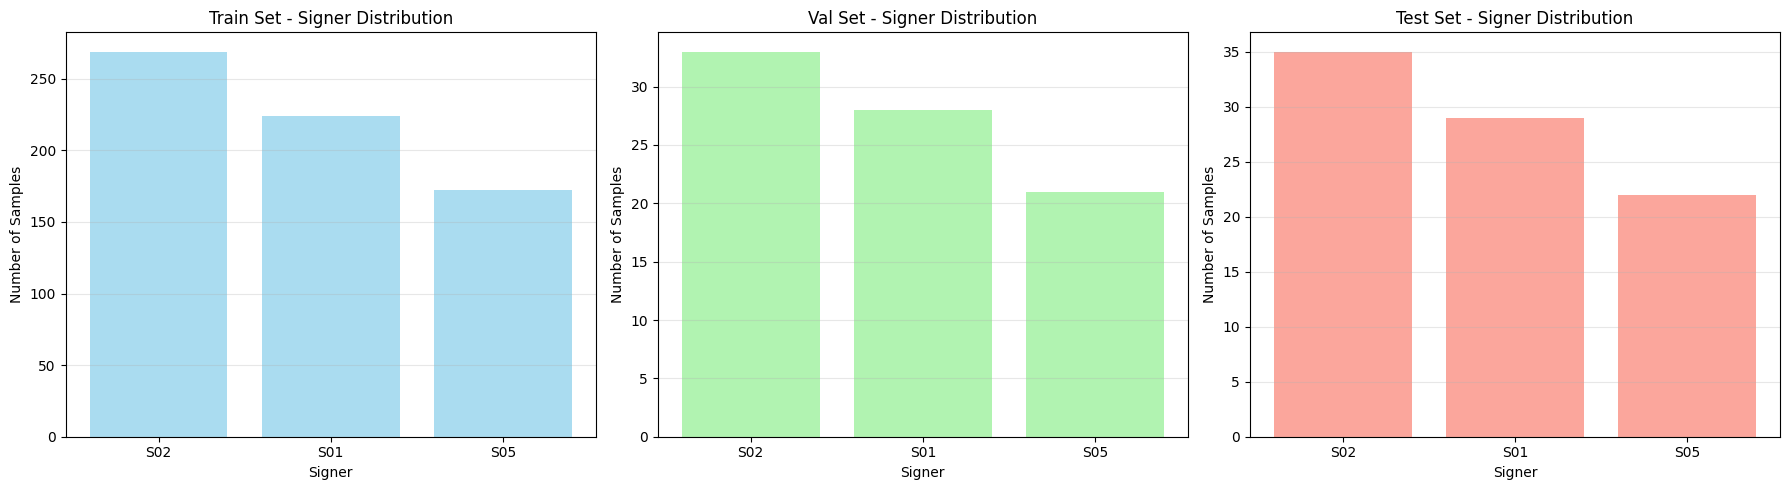

✅ Saved signer distribution plot to /kaggle/working/checkpoints/signer_distribution.png


In [61]:
# Visualize class distribution
plt.style.use('default')
sns.set_palette("husl")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Signer distribution
for idx, (split_name, df, color) in enumerate([
    ('Train', train_df, 'skyblue'),
    ('Val', val_df, 'lightgreen'),
    ('Test', test_df, 'salmon')
]):
    signer_counts = df['signer'].value_counts()
    axes[idx].bar(signer_counts.index, signer_counts.values, color=color, alpha=0.7)
    axes[idx].set_title(f'{split_name} Set - Signer Distribution')
    axes[idx].set_xlabel('Signer')
    axes[idx].set_ylabel('Number of Samples')
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(checkpoint_dir / 'signer_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Saved signer distribution plot to {checkpoint_dir / 'signer_distribution.png'}")

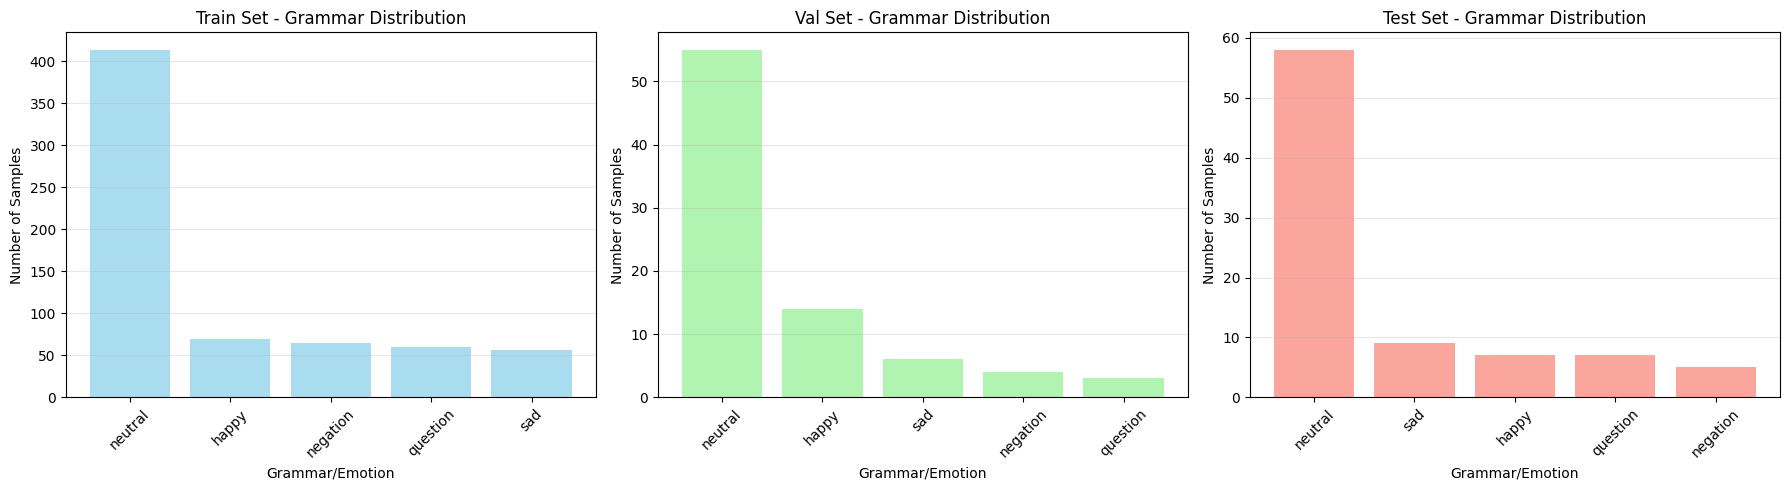

✅ Saved grammar distribution plot to /kaggle/working/checkpoints/grammar_distribution.png


In [62]:
# Grammar distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (split_name, df, color) in enumerate([
    ('Train', train_df, 'skyblue'),
    ('Val', val_df, 'lightgreen'),
    ('Test', test_df, 'salmon')
]):
    grammar_counts = df['grammar'].value_counts()
    axes[idx].bar(grammar_counts.index, grammar_counts.values, color=color, alpha=0.7)
    axes[idx].set_title(f'{split_name} Set - Grammar Distribution')
    axes[idx].set_xlabel('Grammar/Emotion')
    axes[idx].set_ylabel('Number of Samples')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(checkpoint_dir / 'grammar_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Saved grammar distribution plot to {checkpoint_dir / 'grammar_distribution.png'}")

## Section 7: BdSLDataset Implementation

In [63]:

class BdSLDataset(Dataset):
    def __init__(self, sample_paths, word_to_label, normalized_dir,
                 max_seq_length=150, augment=False, mode='train'):
        self.sample_paths = sample_paths
        self.word_to_label = word_to_label
        self.normalized_dir = Path(normalized_dir)
        self.max_seq_length = max_seq_length
        self.augment = augment and (mode == 'train')
        self.mode = mode

        self.metadata_list = [parse_video_metadata(s) for s in sample_paths]
        self.metadata_list = [m for m in self.metadata_list if m is not None]

    def __len__(self):
        return len(self.metadata_list)

    def _npz_path(self, metadata):
        filename = f"{metadata['word']}__{metadata['signer']}__{metadata['session']}__{metadata['repetition']}__{metadata['grammar']}.npz"
        return self.normalized_dir / filename

    def _load_pose_sequence(self, metadata):
        npz_path = self._npz_path(metadata)
        if not npz_path.exists():
            raise FileNotFoundError(f"Missing .npz: {npz_path.name}")
        data = np.load(npz_path)
        if 'pose_sequence' in data:
            pose_sequence = data['pose_sequence']
        else:
            keys = list(data.keys())
            if not keys:
                raise ValueError(f"Empty .npz: {npz_path.name}")
            pose_sequence = data[keys[0]]
            if pose_sequence.ndim == 3:
                pose_sequence = pose_sequence.reshape(pose_sequence.shape[0], -1)
        return np.asarray(pose_sequence, dtype=np.float32)

    def __getitem__(self, idx):
        metadata = self.metadata_list[idx]
        label = self.word_to_label[metadata['word']]

        try:
            pose_sequence = self._load_pose_sequence(metadata)
            seq_length = min(len(pose_sequence), self.max_seq_length)
        except Exception as exc:
            print(f"⚠️  {exc}")
            pose_sequence = np.zeros((self.max_seq_length, CONFIG['input_dim']), dtype=np.float32)
            seq_length = 0

        if pose_sequence.ndim == 3:
            pose_sequence = pose_sequence.reshape(pose_sequence.shape[0], -1)

        if pose_sequence.shape[1] < CONFIG['input_dim']:
            padding = np.zeros((pose_sequence.shape[0], CONFIG['input_dim'] - pose_sequence.shape[1]), dtype=np.float32)
            pose_sequence = np.hstack([pose_sequence, padding])
        elif pose_sequence.shape[1] > CONFIG['input_dim']:
            pose_sequence = pose_sequence[:, :CONFIG['input_dim']]

        pose_sequence = pad_or_crop_centered(pose_sequence, self.max_seq_length).astype(np.float32)

        if self.augment:
            pose_sequence = self._augment_pose_sequence(pose_sequence)

        attention_mask = np.zeros(self.max_seq_length, dtype=np.float32)
        attention_mask[:seq_length] = 1

        return {
            'pose_sequence': torch.FloatTensor(pose_sequence),
            'label': torch.LongTensor([label]),
            'attention_mask': torch.FloatTensor(attention_mask),
            'seq_length': torch.LongTensor([seq_length]),
            'word': metadata['word'],
            'signer': metadata['signer'],
            'grammar': metadata['grammar']
        }

    def _augment_pose_sequence(self, sequence):
        """Apply data augmentation"""
        if np.random.random() > 0.7:
            return sequence

        augmented = sequence.copy()

        if np.random.random() < 0.3:
            scale_factor = np.random.uniform(0.8, 1.2)
            new_length = max(1, int(len(augmented) * scale_factor))
            indices = np.linspace(0, len(augmented) - 1, new_length)
            resampled = []
            for idx in indices:
                lower, upper = int(np.floor(idx)), min(int(np.ceil(idx)), len(augmented) - 1)
                weight = idx - lower
                resampled.append((1 - weight) * augmented[lower] + weight * augmented[upper])
            augmented = np.array(resampled)

            if len(augmented) < self.max_seq_length:
                padding = np.zeros((self.max_seq_length - len(augmented), CONFIG['input_dim']))
                augmented = np.vstack([augmented, padding])
            elif len(augmented) > self.max_seq_length:
                augmented = augmented[:self.max_seq_length]

        if np.random.random() < 0.4:
            noise = np.random.normal(0, 0.02, augmented.shape)
            augmented = augmented + noise

        if np.random.random() < 0.3:
            angle = np.radians(np.random.uniform(-10, 10))
            cos_a, sin_a = np.cos(angle), np.sin(angle)
            for i in range(0, CONFIG['input_dim'], 2):
                if i + 1 < CONFIG['input_dim']:
                    x = augmented[:, i] - 0.5
                    y = augmented[:, i + 1] - 0.5
                    augmented[:, i] = cos_a * x - sin_a * y + 0.5
                    augmented[:, i + 1] = sin_a * x + cos_a * y + 0.5

        return augmented

print("✅ BdSLDataset class updated")


✅ BdSLDataset class updated


## Section 8: Create DataLoaders

In [64]:

normalized_dir = Path(CONFIG['normalized_dir'])

# Create datasets
train_dataset = BdSLDataset(
    train_samples,
    word_to_label,
    normalized_dir,
    max_seq_length=CONFIG['seq_length'],
    augment=CONFIG['augmentation'],
    mode='train'
)

val_dataset = BdSLDataset(
    val_samples,
    word_to_label,
    normalized_dir,
    max_seq_length=CONFIG['seq_length'],
    augment=False,
    mode='val'
)

test_dataset = BdSLDataset(
    test_samples,
    word_to_label,
    normalized_dir,
    max_seq_length=CONFIG['seq_length'],
    augment=False,
    mode='test'
)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'] * 2,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'] * 2,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"✅ DataLoaders created:")
print(f"   Train: {len(train_loader)} batches")
print(f"   Val: {len(val_loader)} batches")
print(f"   Test: {len(test_loader)} batches")
print(f"   Total train samples: {len(train_dataset)}")
print(f"   Total val samples: {len(val_dataset)}")
print(f"   Total test samples: {len(test_dataset)}")


✅ DataLoaders created:
   Train: 42 batches
   Val: 3 batches
   Test: 3 batches
   Total train samples: 665
   Total val samples: 82
   Total test samples: 86


In [65]:
# Test data loading
sample_batch = next(iter(train_loader))
print(f"✅ Sample batch loaded successfully")
print(f"   pose_sequence shape: {sample_batch['pose_sequence'].shape}")
print(f"   label shape: {sample_batch['label'].shape}")
print(f"   attention_mask shape: {sample_batch['attention_mask'].shape}")
print(f"   seq_length shape: {sample_batch['seq_length'].shape}")
print(f"\n   Sample labels: {sample_batch['label'][:5].flatten().tolist()}")
print(f"   Sample words: {[sample_batch['word'][i] for i in range(5)]}")

⚠️  Missing .npz: ধন্যবাদ__S02__sess01__rep02__negation.npz⚠️  Missing .npz: অর্থ__S02__sess01__rep02__question.npz

⚠️  Missing .npz: অবাক__S02__sess01__rep02__negation.npz
⚠️  Missing .npz: দেখা__S05__sess01__rep01__neutral.npz
⚠️  Missing .npz: বিশ্ববিদ্যালয়__S05__sess01__rep01__sad.npz⚠️  Missing .npz: অর্থ__S05__sess01__rep02__neutral.npz

⚠️  Missing .npz: ভাষা__S02__sess01__rep02__neutral.npz⚠️  Missing .npz: উত্তর__S02__sess01__rep05__neutral.npz

⚠️  Missing .npz: অসুস্থ__S02__sess01__rep01__neutral.npz⚠️  Missing .npz: দুঃখ__S02__sess01__rep02__happy.npz
⚠️  Missing .npz: দুঃখ__S01__sess01__rep05__neutral.npz

⚠️  Missing .npz: বিজ্ঞান__S02__sess01__rep05__neutral.npz
⚠️  Missing .npz: ভাষা__S02__sess01__rep05__neutral.npz
⚠️  Missing .npz: আমরা__S01__sess01__rep05__neutral.npz⚠️  Missing .npz: গণিত__S01__sess01__rep03__negation.npz

⚠️  Missing .npz: সঠিক__S01__sess01__rep04__question.npz
⚠️  Missing .npz: বন্ধু__S02__sess01__rep01__neutral.npz
⚠️  Missing .npz: কবে__S02__s

## Section 9: Positional Encoding

In [66]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length=150):
        super(PositionalEncoding, self).__init__()
        
        # Create positional encoding matrix
        pe = torch.zeros(max_seq_length + 1, d_model)
        position = torch.arange(0, max_seq_length + 1, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                           (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        """Add positional encoding to input"""
        # x shape: (batch_size, seq_len, d_model)
        # pe shape: (1, max_seq_len + 1, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return x

print("✅ PositionalEncoding class implemented")

✅ PositionalEncoding class implemented


## Section 10: ProductionSPOTER Model

In [67]:
class ProductionSPOTER(nn.Module):
    def __init__(self, input_dim=108, d_model=108, num_heads=9,
                 num_encoder_layers=8, d_ff=512, num_classes=72,
                 max_seq_length=150, dropout=0.15):
        super(ProductionSPOTER, self).__init__()
        
        self.d_model = d_model
        self.max_seq_length = max_seq_length
        
        # Input projection
        self.input_projection = nn.Sequential(
            nn.Linear(input_dim, d_model),
            nn.LayerNorm(d_model),
            nn.Dropout(dropout * 0.5)
        )
        
        # Positional encoding
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)
        
        # Class token
        self.class_token = nn.Parameter(torch.randn(1, 1, d_model) * 0.1)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(d_model // 2, num_classes)
        )
    
    def forward(self, x, attention_mask=None):
        """
        Forward pass
        Args:
            x: (batch_size, seq_len, input_dim)
            attention_mask: (batch_size, seq_len) - 1 for real, 0 for padding
        Returns:
            logits: (batch_size, num_classes)
        """
        batch_size, seq_len, _ = x.shape
        
        # Project input
        x = self.input_projection(x)
        
        # Add class token
        class_tokens = self.class_token.expand(batch_size, -1, -1)
        x = torch.cat([class_tokens, x], dim=1)
        
        # Add positional encoding
        x = self.positional_encoding(x)
        
        # Prepare attention mask for transformer
        if attention_mask is not None:
            # Add mask for class token (always attend)
            class_mask = torch.ones(batch_size, 1, device=attention_mask.device)
            full_mask = torch.cat([class_mask, attention_mask], dim=1)
            # Convert to transformer format (True = masked, False = attend)
            transformer_mask = (full_mask == 0)
        else:
            transformer_mask = None
        
        # Transformer encoder
        encoded = self.transformer_encoder(x, src_key_padding_mask=transformer_mask)
        
        # Use class token for classification
        class_representation = encoded[:, 0]
        
        # Classification
        logits = self.classifier(class_representation)
        
        return logits

print("✅ ProductionSPOTER model implemented")

✅ ProductionSPOTER model implemented


## Section 11: Initialize Model

In [68]:
model = ProductionSPOTER(
    input_dim=CONFIG['input_dim'],
    d_model=CONFIG['d_model'],
    num_heads=CONFIG['num_heads'],
    num_encoder_layers=CONFIG['num_encoder_layers'],
    d_ff=CONFIG['d_ff'],
    num_classes=CONFIG['num_classes'],
    max_seq_length=CONFIG['seq_length'],
    dropout=CONFIG['dropout']
).to(device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✅ Model initialized successfully")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: {total_params * 4 / 1024**2:.2f} MB (float32)")

✅ Model initialized successfully
   Total parameters: 1,303,786
   Trainable parameters: 1,303,786
   Model size: 4.97 MB (float32)


In [69]:
# Test forward pass
test_batch_size = 4
test_input = torch.randn(test_batch_size, CONFIG['seq_length'], CONFIG['input_dim']).to(device)
test_mask = torch.ones(test_batch_size, CONFIG['seq_length']).to(device)

with torch.no_grad():
    logits = model(test_input, test_mask)

print(f"✅ Forward pass test successful")
print(f"   Input shape: {test_input.shape}")
print(f"   Output shape: {logits.shape}")
print(f"   Expected output shape: ({test_batch_size}, {CONFIG['num_classes']})")

✅ Forward pass test successful
   Input shape: torch.Size([4, 150, 108])
   Output shape: torch.Size([4, 72])
   Expected output shape: (4, 72)


## Section 12: WandB Setup

In [70]:
import wandb

# WandB initialization
wandb.init(
    project="bangla-sign-language-recognition",
    entity=None,  # Auto-detect
    config=CONFIG,
    name=f"BdSL_SPOTER_{len(train_samples)}samples_{CONFIG['epochs']}epochs_{CONFIG['batch_size']}batch"
)

# Watch model for gradients and parameters
wandb.watch(model, log_freq=100)

print("✅ WandB initialized")
print(f"   Project: bangla-sign-language-recognition")
print(f"   Run name: BdSL_SPOTER_{len(train_samples)}samples_{CONFIG['epochs']}epochs_{CONFIG['batch_size']}batch")

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

## Section 13: Training Utilities

In [71]:
from torch.optim.lr_scheduler import OneCycleLR

# Optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay'],
    betas=(0.9, 0.95),
    eps=1e-8
)

# Learning rate scheduler
total_steps = len(train_loader) * CONFIG['epochs']
scheduler = OneCycleLR(
    optimizer,
    max_lr=CONFIG['learning_rate'] * 3,  # Peak LR = 3x base
    epochs=CONFIG['epochs'],
    steps_per_epoch=len(train_loader),
    pct_start=0.1,  # 10% warmup
    anneal_strategy='cos'
)

# Loss function with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=CONFIG['label_smoothing'])

print("✅ Training utilities configured")
print(f"   Optimizer: AdamW (lr={CONFIG['learning_rate']}, weight_decay={CONFIG['weight_decay']})")
print(f"   Scheduler: OneCycleLR (max_lr={CONFIG['learning_rate'] * 3:.6f})")
print(f"   Loss: CrossEntropy (label_smoothing={CONFIG['label_smoothing']})")

✅ Training utilities configured
   Optimizer: AdamW (lr=0.0003, weight_decay=0.05)
   Scheduler: OneCycleLR (max_lr=0.000900)
   Loss: CrossEntropy (label_smoothing=0.1)


In [72]:
def train_epoch(model, dataloader, criterion, optimizer, scheduler, device):
    """
    Train for one epoch
    """
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    for batch in tqdm(dataloader, desc="Training", leave=False):
        pose_sequences = batch['pose_sequence'].to(device)
        labels = batch['label'].squeeze().to(device)
        attention_masks = batch['attention_mask'].to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(pose_sequences, attention_masks)
        loss = criterion(logits, labels)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Optimizer step
        optimizer.step()
        scheduler.step()
        
        # Metrics
        total_loss += loss.item() * len(labels)
        predictions = torch.argmax(logits, dim=1)
        total_correct += (predictions == labels).sum().item()
        total_samples += len(labels)
    
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


def validate(model, dataloader, criterion, device):
    """
    Validate the model
    """
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation", leave=False):
            pose_sequences = batch['pose_sequence'].to(device)
            labels = batch['label'].squeeze().to(device)
            attention_masks = batch['attention_mask'].to(device)
            
            # Forward pass
            logits = model(pose_sequences, attention_masks)
            loss = criterion(logits, labels)
            
            # Metrics
            total_loss += loss.item() * len(labels)
            predictions = torch.argmax(logits, dim=1)
            total_correct += (predictions == labels).sum().item()
            total_samples += len(labels)
    
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

print("✅ Training/validation functions defined")

✅ Training/validation functions defined


## Section 14: Training Loop (50 Epochs)

In [73]:
best_val_acc = 0.0
no_improve_count = 0
patience = CONFIG['early_stopping_patience']
history = {
    'train_loss': [], 
    'train_acc': [], 
    'val_loss': [], 
    'val_acc': [],
    'learning_rate': []
}

print(f"🚀 Starting training for {CONFIG['epochs']} epochs")
print(f"   Early stopping patience: {patience}")
print(f"   Primary metric: {CONFIG['primary_metric']}")
print(f"   Checkpoint directory: {checkpoint_dir}")

for epoch in range(CONFIG['epochs']):
    print(f"\n{'='*70}")
    print(f"Epoch {epoch + 1}/{CONFIG['epochs']}")
    print(f"{'='*70}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scheduler, device)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Get current learning rate
    current_lr = scheduler.get_last_lr()[0]
    
    # Log to WandB
    wandb.log({
        'epoch': epoch + 1,
        'train/loss': train_loss,
        'train/accuracy': train_acc,
        'val/loss': val_loss,
        'val/accuracy': val_acc,
        'learning_rate': current_lr
    })
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['learning_rate'].append(current_lr)
    
    # Print summary
    print(f"\n📊 Epoch {epoch + 1} Summary:")
    print(f"   Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"   Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f} ({val_acc*100:.2f}%)")
    print(f"   LR: {current_lr:.6f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve_count = 0
        
        # Save checkpoint
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_accuracy': val_acc,
            'val_loss': val_loss,
            'config': CONFIG
        }, checkpoint_dir / 'best_model.pth')
        
        print(f"   ✨ New best model saved! Val Acc: {val_acc:.4f} ({val_acc*100:.2f}%)")
        wandb.save(str(checkpoint_dir / 'best_model.pth'))
    else:
        no_improve_count += 1
        print(f"   No improvement for {no_improve_count} epochs")
    
    # Early stopping check
    if no_improve_count >= patience:
        print(f"\n⏹️  Early stopping triggered after {patience} epochs without improvement")
        print(f"   Best validation accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
        break

print(f"\n✅ Training complete!")
print(f"   Total epochs trained: {epoch + 1}")
print(f"   Best validation accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")

🚀 Starting training for 50 epochs
   Early stopping patience: 15
   Primary metric: top-1_accuracy
   Checkpoint directory: /kaggle/working/checkpoints

Epoch 1/50


Training:   0%|          | 0/42 [00:00<?, ?it/s]

⚠️  Missing .npz: তুমি__S01__sess01__rep04__neutral.npz
⚠️  Missing .npz: গরম__S05__sess01__rep01__neutral.npz
⚠️  Missing .npz: হ্যালো__S02__sess01__rep02__neutral.npz
⚠️  Missing .npz: কাজ__S02__sess01__rep03__neutral.npz
⚠️  Missing .npz: সুন্দর__S05__sess01__rep02__happy.npz
⚠️  Missing .npz: পড়া__S02__sess01__rep03__neutral.npz
⚠️  Missing .npz: হ্যাঁ__S02__sess01__rep03__neutral.npz⚠️  Missing .npz: কি__S02__sess01__rep01__neutral.npz

⚠️  Missing .npz: উদাহরণ__S02__sess01__rep01__neutral.npz⚠️  Missing .npz: বাংলাদেশ__S02__sess01__rep04__neutral.npz

⚠️  Missing .npz: ব্যাখ্যা__S02__sess01__rep02__neutral.npz⚠️  Missing .npz: খারাপ__S05__sess01__rep01__neutral.npz

⚠️  Missing .npz: গণিত__S01__sess01__rep04__negation.npz⚠️  Missing .npz: মহাবিশ্ব__S01__sess01__rep03__neutral.npz

⚠️  Missing .npz: বিশ্ববিদ্যালয়__S02__sess01__rep02__neutral.npz
⚠️  Missing .npz: কোথায়__S02__sess01__rep02__neutral.npz
⚠️  Missing .npz: তুমি__S01__sess01__rep01__neutral.npz⚠️  Missing .npz: গণিত__

Training:   2%|▏         | 1/42 [00:01<00:54,  1.34s/it]

⚠️  Missing .npz: হ্যালো__S05__sess01__rep02__neutral.npz
⚠️  Missing .npz: নাম__S01__sess01__rep02__neutral.npz
⚠️  Missing .npz: খাওয়া__S01__sess01__rep01__neutral.npz
⚠️  Missing .npz: রাগ__S05__sess01__rep01__neutral.npz
⚠️  Missing .npz: শোনা__S02__sess01__rep01__neutral.npz
⚠️  Missing .npz: উত্তর__S02__sess01__rep03__neutral.npz
⚠️  Missing .npz: সকাল__S05__sess01__rep02__neutral.npz
⚠️  Missing .npz: শোনা__S02__sess01__rep02__negation.npz
⚠️  Missing .npz: সঠিক__S05__sess01__rep01__question.npz
⚠️  Missing .npz: কি__S05__sess01__rep02__question.npz
⚠️  Missing .npz: হ্যা__S05__sess01__rep01__neutral.npz
⚠️  Missing .npz: ভাষা__S01__sess01__rep03__neutral.npz
⚠️  Missing .npz: সঠিক__S05__sess01__rep02__neutral.npz
⚠️  Missing .npz: খারাপ__S02__sess01__rep02__sad.npz
⚠️  Missing .npz: পছন্দ__S05__sess01__rep01__happy.npz
⚠️  Missing .npz: হ্যালো__S05__sess01__rep01__neutral.npz
⚠️  Missing .npz: মহাবিশ্ব__S01__sess01__rep01__neutral.npz
⚠️  Missing .npz: পৃথিবী__S02__sess01__r

Training:   7%|▋         | 3/42 [00:01<00:15,  2.55it/s]


⚠️  Missing .npz: রাগ__S01__sess01__rep01__neutral.npz
⚠️  Missing .npz: কেন__S05__sess01__rep02__question.npz
⚠️  Missing .npz: খুশি__S02__sess01__rep02__sad.npz
⚠️  Missing .npz: পৃথিবী__S02__sess01__rep04__neutral.npz
⚠️  Missing .npz: ভালো__S01__sess01__rep05__negation.npz
⚠️  Missing .npz: তুমি__S05__sess01__rep02__neutral.npz
⚠️  Missing .npz: শরীর__S05__sess01__rep02__neutral.npz
⚠️  Missing .npz: ভূগোল__S02__sess01__rep04__neutral.npz
⚠️  Missing .npz: পড়া__S05__sess01__rep02__neutral.npz
⚠️  Missing .npz: ভাষা__S02__sess01__rep01__neutral.npz
⚠️  Missing .npz: প্রশ্ন__S01__sess01__rep02__neutral.npz
⚠️  Missing .npz: পছন্দ__S02__sess01__rep02__happy.npz
⚠️  Missing .npz: রাগ__S02__sess01__rep01__negation.npz
⚠️  Missing .npz: লেখা__S01__sess01__rep03__neutral.npz
⚠️  Missing .npz: সকাল__S05__sess01__rep01__neutral.npz
⚠️  Missing .npz: শোনা__S02__sess01__rep01__negation.npz
⚠️  Missing .npz: কম্পিউটার__S02__sess01__rep01__neutral.npz
⚠️  Missing .npz: ভালো__S05__sess01__rep

Training:  12%|█▏        | 5/42 [00:01<00:08,  4.57it/s]

⚠️  Missing .npz: খুশি__S01__sess01__rep05__negation.npz⚠️  Missing .npz: হ্যালো__S01__sess01__rep02__neutral.npz

⚠️  Missing .npz: ধন্যবাদ__S02__sess01__rep02__happy.npz
⚠️  Missing .npz: সময়__S01__sess01__rep02__neutral.npz
⚠️  Missing .npz: বিশ্ববিদ্যালয়__S05__sess01__rep01__neutral.npz
⚠️  Missing .npz: শোনা__S05__sess01__rep02__neutral.npz
⚠️  Missing .npz: অর্থ__S02__sess01__rep01__question.npz
⚠️  Missing .npz: সময়__S02__sess01__rep01__sad.npz
⚠️  Missing .npz: উদাহরণ__S01__sess01__rep04__question.npz
⚠️  Missing .npz: চিন্তা__S02__sess01__rep01__neutral.npz
⚠️  Missing .npz: বিজ্ঞান__S05__sess01__rep02__neutral.npz
⚠️  Missing .npz: বন্ধু__S02__sess01__rep01__negation.npz
⚠️  Missing .npz: মোবাইল__S01__sess01__rep02__neutral.npz
⚠️  Missing .npz: শোনা__S05__sess01__rep01__negation.npz⚠️  Missing .npz: বলা__S02__sess01__rep02__negation.npz

⚠️  Missing .npz: শোনা__S05__sess01__rep02__negation.npz⚠️  Missing .npz: ধন্যবাদ__S01__sess01__rep05__neutral.npz

⚠️  Missing .npz: দ

Training:  19%|█▉        | 8/42 [00:01<00:04,  7.71it/s]

⚠️  Missing .npz: ভালো__S02__sess01__rep01__neutral.npz
⚠️  Missing .npz: গরম__S05__sess01__rep02__neutral.npz⚠️  Missing .npz: হ্যাঁ__S01__sess01__rep03__neutral.npz

⚠️  Missing .npz: কম্পিউটার__S02__sess01__rep01__sad.npz⚠️  Missing .npz: মোবাইল__S01__sess01__rep04__sad.npz

⚠️  Missing .npz: আমরা__S02__sess01__rep05__neutral.npz⚠️  Missing .npz: ভাষা__S02__sess01__rep02__neutral.npz

⚠️  Missing .npz: আমি__S05__sess01__rep01__neutral.npz⚠️  Missing .npz: সঠিক__S05__sess01__rep02__question.npz
⚠️  Missing .npz: পড়া__S05__sess01__rep01__neutral.npz

⚠️  Missing .npz: গণিত__S01__sess01__rep03__negation.npz
⚠️  Missing .npz: পছন্দ__S02__sess01__rep02__negation.npz
⚠️  Missing .npz: শিক্ষক__S05__sess01__rep02__neutral.npz
⚠️  Missing .npz: চিন্তা__S01__sess01__rep04__neutral.npz
⚠️  Missing .npz: রাগ__S05__sess01__rep01__happy.npz
⚠️  Missing .npz: মোবাইল__S05__sess01__rep01__neutral.npz
⚠️  Missing .npz: ইতিহাস__S02__sess01__rep03__neutral.npz
⚠️  Missing .npz: সকাল__S01__sess01__rep

Training:  26%|██▌       | 11/42 [00:01<00:02, 10.36it/s]


⚠️  Missing .npz: লেখা__S02__sess01__rep03__neutral.npz⚠️  Missing .npz: নাম__S01__sess01__rep05__neutral.npz

⚠️  Missing .npz: বন্ধু__S05__sess01__rep01__happy.npz⚠️  Missing .npz: কবে__S01__sess01__rep02__neutral.npz

⚠️  Missing .npz: কম্পিউটার__S02__sess01__rep02__neutral.npz
⚠️  Missing .npz: ধন্যবাদ__S02__sess01__rep01__happy.npz
⚠️  Missing .npz: বিজ্ঞান__S02__sess01__rep02__neutral.npz
⚠️  Missing .npz: শিক্ষক__S02__sess01__rep05__neutral.npz
⚠️  Missing .npz: কোথায়__S01__sess01__rep01__neutral.npz
⚠️  Missing .npz: বাংলাদেশ__S01__sess01__rep03__neutral.npz
⚠️  Missing .npz: অবাক__S05__sess01__rep01__sad.npz
⚠️  Missing .npz: বিশ্ববিদ্যালয়__S02__sess01__rep02__sad.npz
⚠️  Missing .npz: বই__S02__sess01__rep01__neutral.npz
⚠️  Missing .npz: পছন্দ__S02__sess01__rep01__neutral.npz⚠️  Missing .npz: ভুল__S02__sess01__rep03__neutral.npz

⚠️  Missing .npz: গরম__S02__sess01__rep02__neutral.npz⚠️  Missing .npz: দুঃখ__S02__sess01__rep01__negation.npz

⚠️  Missing .npz: ভুল__S01__sess01

Training:  31%|███       | 13/42 [00:01<00:02, 11.91it/s]

⚠️  Missing .npz: বই__S01__sess01__rep04__sad.npz

⚠️  Missing .npz: পরিবেশ__S02__sess01__rep04__neutral.npz⚠️  Missing .npz: বিদায়__S02__sess01__rep03__neutral.npz
⚠️  Missing .npz: ভাষা__S05__sess01__rep02__neutral.npz

⚠️  Missing .npz: সঠিক__S02__sess01__rep02__question.npz⚠️  Missing .npz: খাওয়া__S01__sess01__rep03__happy.npz

⚠️  Missing .npz: পড়া__S05__sess01__rep02__negation.npz
⚠️  Missing .npz: দুঃখ__S05__sess01__rep01__happy.npz⚠️  Missing .npz: শোনা__S02__sess01__rep03__neutral.npz

⚠️  Missing .npz: ঠান্ডা__S05__sess01__rep01__happy.npz⚠️  Missing .npz: সময়__S02__sess01__rep02__happy.npz
⚠️  Missing .npz: পছন্দ__S02__sess01__rep01__sad.npz
⚠️  Missing .npz: শরীর__S01__sess01__rep04__neutral.npz

⚠️  Missing .npz: দুঃখ__S02__sess01__rep02__happy.npz⚠️  Missing .npz: ভালো__S02__sess01__rep02__sad.npz

⚠️  Missing .npz: সকাল__S01__sess01__rep01__neutral.npz
⚠️  Missing .npz: ঠান্ডা__S02__sess01__rep01__happy.npz
⚠️  Missing .npz: লেখা__S05__sess01__rep01__neutral.npz
⚠️  Mi

Training:  36%|███▌      | 15/42 [00:02<00:02, 13.48it/s]


⚠️  Missing .npz: ঠান্ডা__S01__sess01__rep04__sad.npz⚠️  Missing .npz: থামা__S05__sess01__rep01__neutral.npz

⚠️  Missing .npz: বলা__S02__sess01__rep01__negation.npz
⚠️  Missing .npz: ব্যাখ্যা__S05__sess01__rep02__question.npz⚠️  Missing .npz: অবাক__S01__sess01__rep02__neutral.npz

⚠️  Missing .npz: কালকে__S05__sess01__rep02__neutral.npz
⚠️  Missing .npz: কি__S05__sess01__rep01__neutral.npz⚠️  Missing .npz: লেখা__S01__sess01__rep01__neutral.npz

⚠️  Missing .npz: বন্ধু__S01__sess01__rep01__neutral.npz⚠️  Missing .npz: বন্ধু__S02__sess01__rep02__sad.npz

⚠️  Missing .npz: ভাষা__S02__sess01__rep05__neutral.npz
⚠️  Missing .npz: ভাষা__S01__sess01__rep05__neutral.npz
⚠️  Missing .npz: বই__S02__sess01__rep02__neutral.npz
⚠️  Missing .npz: বলা__S05__sess01__rep02__neutral.npz
⚠️  Missing .npz: পৃথিবী__S01__sess01__rep04__neutral.npz

⚠️  Missing .npz: অর্থ__S05__sess01__rep02__question.npz⚠️  Missing .npz: গণিত__S01__sess01__rep01__neutral.npz⚠️  Missing .npz: থামা__S02__sess01__rep02__neut

Training:  43%|████▎     | 18/42 [00:02<00:01, 15.64it/s]


⚠️  Missing .npz: ভুল__S05__sess01__rep01__question.npz⚠️  Missing .npz: ইতিহাস__S05__sess01__rep02__neutral.npz

⚠️  Missing .npz: গরম__S02__sess01__rep02__sad.npz⚠️  Missing .npz: সকাল__S01__sess01__rep05__negation.npz
⚠️  Missing .npz: হ্যালো__S01__sess01__rep01__neutral.npz
⚠️  Missing .npz: বই__S02__sess01__rep01__happy.npz

⚠️  Missing .npz: অর্থ__S05__sess01__rep02__neutral.npz⚠️  Missing .npz: শোনা__S01__sess01__rep02__neutral.npz

⚠️  Missing .npz: চিন্তা__S02__sess01__rep03__neutral.npz
⚠️  Missing .npz: প্রশ্ন__S05__sess01__rep02__neutral.npz
⚠️  Missing .npz: বন্ধু__S02__sess01__rep01__neutral.npz
⚠️  Missing .npz: দুঃখ__S02__sess01__rep01__neutral.npz
⚠️  Missing .npz: অবাক__S01__sess01__rep03__neutral.npz
⚠️  Missing .npz: অবাক__S02__sess01__rep01__sad.npz
⚠️  Missing .npz: অসুস্থ__S02__sess01__rep02__sad.npz
⚠️  Missing .npz: গরম__S02__sess01__rep01__sad.npz
⚠️  Missing .npz: ভুল__S05__sess01__rep02__neutral.npz⚠️  Missing .npz: রাগ__S02__sess01__rep02__sad.npz

⚠️  Mis

Training:  48%|████▊     | 20/42 [00:02<00:01, 16.37it/s]

⚠️  Missing .npz: গরম__S05__sess01__rep01__sad.npz

⚠️  Missing .npz: পৃথিবী__S05__sess01__rep01__neutral.npz⚠️  Missing .npz: নাম__S02__sess01__rep01__neutral.npz
⚠️  Missing .npz: অবাক__S01__sess01__rep05__neutral.npz⚠️  Missing .npz: খাওয়া__S02__sess01__rep01__negation.npz

⚠️  Missing .npz: অসুস্থ__S02__sess01__rep01__neutral.npz⚠️  Missing .npz: উদাহরণ__S02__sess01__rep01__question.npz

⚠️  Missing .npz: পছন্দ__S02__sess01__rep01__happy.npz
⚠️  Missing .npz: সকাল__S02__sess01__rep01__neutral.npz
⚠️  Missing .npz: উদাহরণ__S02__sess01__rep02__question.npz
⚠️  Missing .npz: ইতিহাস__S05__sess01__rep01__neutral.npz
⚠️  Missing .npz: ধন্যবাদ__S02__sess01__rep02__neutral.npz
⚠️  Missing .npz: কবে__S05__sess01__rep01__question.npz
⚠️  Missing .npz: চিন্তা__S05__sess01__rep02__negation.npz
⚠️  Missing .npz: সুন্দর__S01__sess01__rep04__sad.npz
⚠️  Missing .npz: উত্তর__S05__sess01__rep01__neutral.npz
⚠️  Missing .npz: থামা__S02__sess01__rep01__neutral.npz
⚠️  Missing .npz: ভালো__S02__sess01

Training:  52%|█████▏    | 22/42 [00:02<00:01, 16.98it/s]

⚠️  Missing .npz: পরিবেশ__S01__sess01__rep04__neutral.npz
⚠️  Missing .npz: উত্তর__S02__sess01__rep02__neutral.npz
⚠️  Missing .npz: প্রশ্ন__S01__sess01__rep01__neutral.npz⚠️  Missing .npz: ভুল__S05__sess01__rep01__neutral.npz

⚠️  Missing .npz: কী__S01__sess01__rep04__question.npz
⚠️  Missing .npz: পরিবেশ__S01__sess01__rep02__neutral.npz⚠️  Missing .npz: দেখা__S05__sess01__rep01__neutral.npz

⚠️  Missing .npz: রাগ__S02__sess01__rep02__neutral.npz
⚠️  Missing .npz: অর্থ__S02__sess01__rep03__neutral.npz
⚠️  Missing .npz: ঠান্ডা__S02__sess01__rep02__happy.npz
⚠️  Missing .npz: চিন্তা__S05__sess01__rep01__neutral.npz
⚠️  Missing .npz: কেমন__S05__sess01__rep01__question.npz
⚠️  Missing .npz: শিক্ষক__S01__sess01__rep02__neutral.npz
⚠️  Missing .npz: খাওয়া__S02__sess01__rep02__neutral.npz
⚠️  Missing .npz: ঠান্ডা__S01__sess01__rep05__negation.npz
⚠️  Missing .npz: পৃথিবী__S01__sess01__rep03__neutral.npz
⚠️  Missing .npz: ভালো__S02__sess01__rep02__happy.npz
⚠️  Missing .npz: পছন্দ__S01__sess

Training:  57%|█████▋    | 24/42 [00:02<00:01, 17.73it/s]


⚠️  Missing .npz: পরিবেশ__S01__sess01__rep03__neutral.npz⚠️  Missing .npz: অসুস্থ__S02__sess01__rep02__happy.npz

⚠️  Missing .npz: ভালো__S02__sess01__rep02__negation.npz
⚠️  Missing .npz: ভূগোল__S02__sess01__rep03__neutral.npz
⚠️  Missing .npz: কম্পিউটার__S05__sess01__rep02__neutral.npz⚠️  Missing .npz: আমি__S02__sess01__rep02__neutral.npz

⚠️  Missing .npz: কী__S01__sess01__rep03__question.npz⚠️  Missing .npz: ঠান্ডা__S01__sess01__rep01__neutral.npz

⚠️  Missing .npz: খুশি__S05__sess01__rep02__sad.npz
⚠️  Missing .npz: থামা__S01__sess01__rep01__neutral.npz
⚠️  Missing .npz: উত্তর__S01__sess01__rep05__neutral.npz
⚠️  Missing .npz: অসুস্থ__S05__sess01__rep02__neutral.npz
⚠️  Missing .npz: দুঃখ__S01__sess01__rep02__happy.npz
⚠️  Missing .npz: সঠিক__S01__sess01__rep02__neutral.npz
⚠️  Missing .npz: লেখা__S02__sess01__rep04__neutral.npz
⚠️  Missing .npz: গরম__S01__sess01__rep05__negation.npz
⚠️  Missing .npz: ধন্যবাদ__S01__sess01__rep03__neutral.npz⚠️  Missing .npz: বলা__S05__sess01__rep

Training:  62%|██████▏   | 26/42 [00:02<00:00, 18.32it/s]


⚠️  Missing .npz: বন্ধু__S05__sess01__rep02__happy.npz⚠️  Missing .npz: শিক্ষক__S02__sess01__rep03__neutral.npz

⚠️  Missing .npz: ভুল__S05__sess01__rep02__question.npz
⚠️  Missing .npz: উত্তর__S02__sess01__rep04__neutral.npz
⚠️  Missing .npz: প্রশ্ন__S01__sess01__rep03__neutral.npz⚠️  Missing .npz: সঠিক__S02__sess01__rep01__question.npz

⚠️  Missing .npz: থামা__S05__sess01__rep02__neutral.npz⚠️  Missing .npz: শরীর__S02__sess01__rep05__neutral.npz

⚠️  Missing .npz: মহাবিশ্ব__S01__sess01__rep02__neutral.npz
⚠️  Missing .npz: সাহায্য__S02__sess01__rep01__neutral.npz
⚠️  Missing .npz: খারাপ__S02__sess01__rep02__happy.npz
⚠️  Missing .npz: শিক্ষক__S01__sess01__rep05__neutral.npz
⚠️  Missing .npz: কাল__S01__sess01__rep05__neutral.npz
⚠️  Missing .npz: বলা__S02__sess01__rep03__neutral.npz
⚠️  Missing .npz: বিজ্ঞান__S01__sess01__rep01__neutral.npz
⚠️  Missing .npz: মোবাইল__S02__sess01__rep01__sad.npz
⚠️  Missing .npz: কম্পিউটার__S05__sess01__rep01__sad.npz⚠️  Missing .npz: অসুস্থ__S02__sess

Training:  67%|██████▋   | 28/42 [00:02<00:00, 18.62it/s]


⚠️  Missing .npz: কোথায়__S01__sess01__rep05__question.npz⚠️  Missing .npz: শিক্ষক__S02__sess01__rep02__neutral.npz
⚠️  Missing .npz: দুঃখ__S05__sess01__rep01__sad.npz
⚠️  Missing .npz: পৃথিবী__S02__sess01__rep02__neutral.npz

⚠️  Missing .npz: হ্যাঁ__S02__sess01__rep05__neutral.npz
⚠️  Missing .npz: গরম__S01__sess01__rep03__happy.npz⚠️  Missing .npz: হ্যালো__S02__sess01__rep03__neutral.npz⚠️  Missing .npz: বন্ধু__S02__sess01__rep02__happy.npz


⚠️  Missing .npz: কাল__S01__sess01__rep02__neutral.npz⚠️  Missing .npz: লেখা__S02__sess01__rep01__neutral.npz

⚠️  Missing .npz: পৃথিবী__S01__sess01__rep01__neutral.npz
⚠️  Missing .npz: গরম__S01__sess01__rep04__sad.npz
⚠️  Missing .npz: বলা__S02__sess01__rep01__neutral.npz
⚠️  Missing .npz: ভাষা__S05__sess01__rep01__neutral.npz⚠️  Missing .npz: হ্যালো__S02__sess01__rep04__neutral.npz

⚠️  Missing .npz: সুন্দর__S01__sess01__rep01__neutral.npz⚠️  Missing .npz: কেন__S02__sess01__rep02__neutral.npz

⚠️  Missing .npz: কাজ__S01__sess01__rep03__neutr

Training:  71%|███████▏  | 30/42 [00:02<00:00, 18.88it/s]

⚠️  Missing .npz: আমরা__S05__sess01__rep02__neutral.npz
⚠️  Missing .npz: মোবাইল__S02__sess01__rep01__happy.npz⚠️  Missing .npz: বই__S05__sess01__rep02__happy.npz

⚠️  Missing .npz: হ্যাঁ__S01__sess01__rep01__neutral.npz
⚠️  Missing .npz: বই__S05__sess01__rep02__neutral.npz⚠️  Missing .npz: আমরা__S05__sess01__rep01__neutral.npz

⚠️  Missing .npz: লেখা__S05__sess01__rep02__negation.npz⚠️  Missing .npz: নাম__S02__sess01__rep05__neutral.npz

⚠️  Missing .npz: ভালো__S01__sess01__rep02__happy.npz
⚠️  Missing .npz: বাংলাদেশ__S02__sess01__rep01__neutral.npz
⚠️  Missing .npz: ব্যাখ্যা__S05__sess01__rep01__question.npz
⚠️  Missing .npz: গণিত__S05__sess01__rep02__neutral.npz
⚠️  Missing .npz: সকাল__S01__sess01__rep02__neutral.npz
⚠️  Missing .npz: কবে__S01__sess01__rep03__neutral.npz
⚠️  Missing .npz: বন্ধু__S05__sess01__rep02__negation.npz
⚠️  Missing .npz: সময়__S02__sess01__rep01__neutral.npz
⚠️  Missing .npz: বাংলাদেশ__S05__sess01__rep01__neutral.npz
⚠️  Missing .npz: সঠিক__S02__sess01__rep01

Training:  79%|███████▊  | 33/42 [00:02<00:00, 19.40it/s]

⚠️  Missing .npz: বন্ধু__S02__sess01__rep01__happy.npz⚠️  Missing .npz: ঠান্ডা__S05__sess01__rep01__sad.npz

⚠️  Missing .npz: বিদায়__S01__sess01__rep01__neutral.npz⚠️  Missing .npz: গরম__S02__sess01__rep01__neutral.npz

⚠️  Missing .npz: অর্থ__S01__sess01__rep02__neutral.npz
⚠️  Missing .npz: পছন্দ__S01__sess01__rep04__sad.npz⚠️  Missing .npz: লেখা__S05__sess01__rep01__negation.npz

⚠️  Missing .npz: রাগ__S05__sess01__rep02__neutral.npz
⚠️  Missing .npz: শরীর__S01__sess01__rep03__neutral.npz
⚠️  Missing .npz: বিজ্ঞান__S02__sess01__rep05__neutral.npz
⚠️  Missing .npz: বাংলাদেশ__S05__sess01__rep02__neutral.npz
⚠️  Missing .npz: খাওয়া__S02__sess01__rep02__negation.npz
⚠️  Missing .npz: কালকে__S05__sess01__rep02__question.npz⚠️  Missing .npz: লেখা__S01__sess01__rep04__happy.npz

⚠️  Missing .npz: বন্ধু__S02__sess01__rep01__sad.npz
⚠️  Missing .npz: হ্যাঁ__S01__sess01__rep04__neutral.npz⚠️  Missing .npz: দুঃখ__S01__sess01__rep05__neutral.npz

⚠️  Missing .npz: দেখা__S05__sess01__rep02__ne

Training:  86%|████████▌ | 36/42 [00:03<00:00, 19.92it/s]


⚠️  Missing .npz: আমরা__S01__sess01__rep04__neutral.npz⚠️  Missing .npz: মহাবিশ্ব__S02__sess01__rep02__neutral.npz
⚠️  Missing .npz: বই__S05__sess01__rep01__sad.npz

⚠️  Missing .npz: ভালো__S01__sess01__rep01__neutral.npz
⚠️  Missing .npz: কাজ__S01__sess01__rep02__neutral.npz⚠️  Missing .npz: খাওয়া__S05__sess01__rep01__neutral.npz

⚠️  Missing .npz: ইতিহাস__S01__sess01__rep01__neutral.npz
⚠️  Missing .npz: অর্থ__S05__sess01__rep01__question.npz⚠️  Missing .npz: বাংলাদেশ__S01__sess01__rep05__neutral.npz

⚠️  Missing .npz: খুশি__S02__sess01__rep02__happy.npz⚠️  Missing .npz: কবে__S01__sess01__rep05__question.npz

⚠️  Missing .npz: ভূগোল__S02__sess01__rep05__neutral.npz
⚠️  Missing .npz: খুশি__S01__sess01__rep02__happy.npz
⚠️  Missing .npz: উত্তর__S01__sess01__rep01__neutral.npz
⚠️  Missing .npz: খুশি__S01__sess01__rep01__neutral.npz
⚠️  Missing .npz: অসুস্থ__S05__sess01__rep01__sad.npz
⚠️  Missing .npz: অর্থ__S02__sess01__rep02__neutral.npz⚠️  Missing .npz: শিক্ষক__S05__sess01__rep01__

Validation:   0%|          | 0/3 [00:00<?, ?it/s]        

⚠️  Missing .npz: বিদায়__S02__sess01__rep02__neutral.npz
⚠️  Missing .npz: অবাক__S02__sess01__rep02__happy.npz
⚠️  Missing .npz: কেমন__S02__sess01__rep01__question.npz
⚠️  Missing .npz: বিজ্ঞান__S02__sess01__rep04__neutral.npz⚠️  Missing .npz: শরীর__S02__sess01__rep03__neutral.npz

⚠️  Missing .npz: নাম__S02__sess01__rep04__neutral.npz⚠️  Missing .npz: ইতিহাস__S01__sess01__rep02__neutral.npz

⚠️  Missing .npz: থামা__S01__sess01__rep02__neutral.npz⚠️  Missing .npz: মহাবিশ্ব__S02__sess01__rep01__neutral.npz

⚠️  Missing .npz: খারাপ__S02__sess01__rep01__happy.npz⚠️  Missing .npz: কম্পিউটার__S01__sess01__rep02__neutral.npz

⚠️  Missing .npz: বই__S02__sess01__rep02__happy.npz⚠️  Missing .npz: ধন্যবাদ__S01__sess01__rep04__neutral.npz
⚠️  Missing .npz: থামা__S01__sess01__rep03__neutral.npz

⚠️  Missing .npz: কবে__S02__sess01__rep01__question.npz⚠️  Missing .npz: বলা__S01__sess01__rep01__neutral.npz

⚠️  Missing .npz: খুশি__S01__sess01__rep03__sad.npz⚠️  Missing .npz: রাগ__S02__sess01__rep01__

Validation:  33%|███▎      | 1/3 [00:00<00:00,  4.44it/s]


⚠️  Missing .npz: কম্পিউটার__S05__sess01__rep02__happy.npz
⚠️  Missing .npz: পড়া__S05__sess01__rep01__negation.npz


Error: You must call wandb.init() before wandb.log()

## Section 15: Load Best Model

In [ ]:
# Load best checkpoint
checkpoint = torch.load(checkpoint_dir / 'best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

print(f"✅ Loaded best model from epoch {checkpoint['epoch']}")
print(f"   Validation accuracy: {checkpoint['val_accuracy']:.4f} ({checkpoint['val_accuracy']*100:.2f}%)")
print(f"   Validation loss: {checkpoint['val_loss']:.4f}")

## Section 16: Test Evaluation

In [ ]:
# Evaluate on test set
model.eval()
all_predictions = []
all_labels = []
all_words = []
all_signers = []
all_probs = []

print("🔍 Evaluating on test set...")

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        pose_sequences = batch['pose_sequence'].to(device)
        labels = batch['label'].squeeze().to(device)
        words = batch['word']
        signers = batch['signer']
        
        # Forward pass
        logits = model(pose_sequences)
        probs = F.softmax(logits, dim=1)
        predictions = torch.argmax(logits, dim=1)
        
        # Collect results
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_words.extend(words)
        all_signers.extend(signers)
        all_probs.extend(probs.cpu().numpy())

print(f"✅ Test evaluation complete")
print(f"   Total test samples: {len(all_predictions)}")

In [ ]:
# Calculate overall metrics
test_accuracy = accuracy_score(all_labels, all_predictions)
test_precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
test_recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
test_f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)

print(f"\n📊 Test Results:")
print(f"{'='*50}")
print(f"Top-1 Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Precision (macro): {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"Recall (macro): {test_recall:.4f} ({test_recall*100:.2f}%)")
print(f"F1-Score (macro): {test_f1:.4f} ({test_f1*100:.2f}%)")

# Log to WandB
wandb.log({
    'test/accuracy': test_accuracy,
    'test/precision': test_precision,
    'test/recall': test_recall,
    'test/f1_score': test_f1
})

print(f"\n✅ Metrics logged to WandB")

## Section 17: Per-Signer Analysis

In [ ]:
# Calculate accuracy per signer
signer_accuracies = {}
signer_counts = {}

print(f"\n📊 Per-Signer Analysis:")
print(f"{'='*50}")

for signer in ['S01', 'S02', 'S05']:
    signer_indices = [i for i, s in enumerate(all_signers) if s == signer]
    if signer_indices:
        signer_labels = [all_labels[i] for i in signer_indices]
        signer_preds = [all_predictions[i] for i in signer_indices]
        acc = accuracy_score(signer_labels, signer_preds)
        signer_accuracies[signer] = acc
        signer_counts[signer] = len(signer_indices)
        print(f"{signer}: {acc:.4f} ({acc*100:.2f}%) - {len(signer_indices)} samples")

# Log to WandB
wandb.log({'test/signer_accuracies': signer_accuracies})

print(f"\n✅ Per-signer accuracies logged to WandB")

In [ ]:
# Visualize per-signer accuracy
fig, ax = plt.subplots(figsize=(10, 6))
signers = list(signer_accuracies.keys())
accuracies = [signer_accuracies[s] * 100 for s in signers]
counts = [signer_counts[s] for s in signers]

bars = ax.bar(signers, accuracies, color=['#3498db', '#2ecc71', '#e74c3c'], alpha=0.8)
ax.set_xlabel('Signer', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Per-Signer Test Accuracy', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3)

# Add sample count labels on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}%\n(n={count})',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(checkpoint_dir / 'per_signer_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

# Log to WandB
wandb.log({'test/per_signer_accuracy_plot': wandb.Image(str(checkpoint_dir / 'per_signer_accuracy.png'))})

print(f"✅ Per-signer accuracy plot saved and logged to WandB")

## Section 18: Confusion Matrix & Visualization

In [ ]:
# Create confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Normalize by row (true labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

print(f"✅ Confusion matrix created")
print(f"   Shape: {cm.shape}")
print(f"   Total samples: {cm.sum()}")

In [ ]:
# Plot confusion matrix (full 72x72)
plt.style.use('default')
fig, ax = plt.subplots(figsize=(24, 20))

# Create heatmap with short labels
short_labels = [label_to_word[i][:8] + '..' if len(label_to_word[i]) > 10 else label_to_word[i] 
               for i in range(72)]

sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=short_labels,
            yticklabels=short_labels,
            ax=ax, cbar_kws={'label': 'Count'})

ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('Confusion Matrix (72 Classes)', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)

plt.tight_layout()
plt.savefig(checkpoint_dir / 'confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Log to WandB
wandb.log({'test/confusion_matrix': wandb.Image(str(checkpoint_dir / 'confusion_matrix.png'))})

print(f"✅ Confusion matrix saved and logged to WandB")

In [ ]:
# Plot normalized confusion matrix
fig, ax = plt.subplots(figsize=(24, 20))

sns.heatmap(cm_normalized, annot=False, fmt='.2f', cmap='Blues', 
            xticklabels=short_labels,
            yticklabels=short_labels,
            ax=ax, cbar_kws={'label': 'Normalized Count'},
            vmin=0, vmax=1)

ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('Normalized Confusion Matrix (72 Classes)', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)

plt.tight_layout()
plt.savefig(checkpoint_dir / 'confusion_matrix_normalized.png', dpi=150, bbox_inches='tight')
plt.show()

# Log to WandB
wandb.log({'test/confusion_matrix_normalized': wandb.Image(str(checkpoint_dir / 'confusion_matrix_normalized.png'))})

print(f"✅ Normalized confusion matrix saved and logged to WandB")

## Section 19: Training Curves

In [ ]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss curves
axes[0, 0].plot(history['train_loss'], label='Train', linewidth=2)
axes[0, 0].plot(history['val_loss'], label='Validation', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Loss', fontsize=11)
axes[0, 0].set_title('Training Loss', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Accuracy curves
axes[0, 1].plot(history['train_acc'], label='Train', linewidth=2)
axes[0, 1].plot(history['val_acc'], label='Validation', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('Accuracy', fontsize=11)
axes[0, 1].set_title('Training Accuracy', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Learning rate curve
axes[1, 0].plot(history['learning_rate'], linewidth=2, color='orange')
axes[1, 0].set_xlabel('Epoch', fontsize=11)
axes[1, 0].set_ylabel('Learning Rate', fontsize=11)
axes[1, 0].set_title('Learning Rate Schedule', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Combined plot
ax4 = axes[1, 1]
ax4.plot(history['train_acc'], label='Train Acc', linewidth=2, color='blue')
ax4.plot(history['val_acc'], label='Val Acc', linewidth=2, color='red')
ax4.set_xlabel('Epoch', fontsize=11)
ax4.set_ylabel('Accuracy', fontsize=11)
ax4.set_title('Accuracy Comparison', fontsize=13, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(checkpoint_dir / 'training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# Log to WandB
wandb.log({'training_curves': wandb.Image(str(checkpoint_dir / 'training_curves.png'))})

print(f"✅ Training curves saved and logged to WandB")

## Section 20: Top-5 Accuracy Analysis

In [ ]:
# Calculate top-5 accuracy
def top_k_accuracy(labels, probs, k=5):
    """
    Calculate top-k accuracy
    Args:
        labels: true labels (batch_size,)
        probs: predicted probabilities (batch_size, num_classes)
        k: top-k to consider
    """
    top_k_preds = np.argsort(probs, axis=1)[:, -k:]
    correct = 0
    for i, label in enumerate(labels):
        if label in top_k_preds[i]:
            correct += 1
    return correct / len(labels)

# Calculate top-5 accuracy
all_probs_array = np.array(all_probs)
top5_acc = top_k_accuracy(all_labels, all_probs_array, k=5)

print(f"\n📊 Top-K Accuracy:")
print(f"{'='*50}")
print(f"Top-1 Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Top-5 Accuracy: {top5_acc:.4f} ({top5_acc*100:.2f}%)")

# Log to WandB
wandb.log({
    'test/top5_accuracy': top5_acc
})

print(f"\n✅ Top-5 accuracy logged to WandB")

## Section 21: Per-Class Analysis

In [ ]:
# Calculate per-class accuracy
from collections import defaultdict

class_correct = defaultdict(int)
class_total = defaultdict(int)

for true_label, pred_label in zip(all_labels, all_predictions):
    class_total[true_label] += 1
    if true_label == pred_label:
        class_correct[true_label] += 1

per_class_accuracy = {}
for label_id in range(CONFIG['num_classes']):
    if class_total[label_id] > 0:
        per_class_accuracy[label_id] = class_correct[label_id] / class_total[label_id]
    else:
        per_class_accuracy[label_id] = 0.0

# Create DataFrame for easy analysis
class_df = pd.DataFrame([
    {'label_id': i, 'word': label_to_word[i], 'accuracy': per_class_accuracy[i], 
     'correct': class_correct[i], 'total': class_total[i]}
    for i in range(CONFIG['num_classes'])
])

# Sort by accuracy
class_df = class_df.sort_values('accuracy')

# Show worst and best performing classes
print(f"\n📊 Per-Class Analysis:")
print(f"{'='*70}")
print(f"\nWorst 5 performing classes:")
print(class_df.head(5).to_string(index=False))

print(f"\nBest 5 performing classes:")
print(class_df.tail(5)[::-1].to_string(index=False))

In [ ]:
# Plot per-class accuracy distribution
fig, ax = plt.subplots(figsize=(15, 6))

ax.bar(range(CONFIG['num_classes']), 
       [per_class_accuracy[i] * 100 for i in range(CONFIG['num_classes'])],
       color='steelblue', alpha=0.7)

ax.set_xlabel('Class ID', fontsize=11)
ax.set_ylabel('Accuracy (%)', fontsize=11)
ax.set_title('Per-Class Accuracy (72 Classes)', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)
ax.axhline(y=test_accuracy*100, color='red', linestyle='--', linewidth=2, label=f'Overall Accuracy: {test_accuracy*100:.1f}%')
ax.grid(axis='y', alpha=0.3)
ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig(checkpoint_dir / 'per_class_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

# Log to WandB
wandb.log({'test/per_class_accuracy_plot': wandb.Image(str(checkpoint_dir / 'per_class_accuracy.png'))})

print(f"✅ Per-class accuracy plot saved and logged to WandB")

## Section 22: Save Final Results

In [ ]:
# Save comprehensive test results
results = {
    'test_accuracy': float(test_accuracy),
    'test_precision': float(test_precision),
    'test_recall': float(test_recall),
    'test_f1_score': float(test_f1),
    'test_top5_accuracy': float(top5_acc),
    'signer_accuracies': {k: float(v) for k, v in signer_accuracies.items()},
    'signer_counts': {k: int(v) for k, v in signer_counts.items()},
    'best_val_accuracy': float(best_val_acc),
    'best_epoch': int(checkpoint['epoch']),
    'total_epochs_trained': int(checkpoint['epoch']),
    'model_parameters': int(total_params),
    'config': CONFIG,
    'per_class_accuracy': {i: float(per_class_accuracy[i]) for i in range(CONFIG['num_classes'])}
}

with open(checkpoint_dir / 'test_results.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

print(f"✅ Test results saved to {checkpoint_dir / 'test_results.json'}")

# Also save as CSV for easy viewing
results_df = pd.DataFrame([
    {'Metric': 'Test Accuracy', 'Value': f"{test_accuracy:.4f} ({test_accuracy*100:.2f}%)"},
    {'Metric': 'Test Precision (macro)', 'Value': f"{test_precision:.4f} ({test_precision*100:.2f}%)"},
    {'Metric': 'Test Recall (macro)', 'Value': f"{test_recall:.4f} ({test_recall*100:.2f}%)"},
    {'Metric': 'Test F1-Score (macro)', 'Value': f"{test_f1:.4f} ({test_f1*100:.2f}%)"},
    {'Metric': 'Top-5 Accuracy', 'Value': f"{top5_acc:.4f} ({top5_acc*100:.2f}%)"},
    {'Metric': 'Best Val Accuracy', 'Value': f"{best_val_acc:.4f} ({best_val_acc*100:.2f}%)"},
    {'Metric': 'Best Epoch', 'Value': str(checkpoint['epoch'])},
    {'Metric': 'Total Parameters', 'Value': f"{total_params:,}"},
    {'Metric': 'Model Size (MB)', 'Value': f"{total_params * 4 / 1024**2:.2f}"},
])

results_df.to_csv(checkpoint_dir / 'test_results_summary.csv', index=False)
print(f"✅ Test results summary saved to {checkpoint_dir / 'test_results_summary.csv'}")

In [ ]:
# Save final model
torch.save(model.state_dict(), checkpoint_dir / 'final_model.pth')
wandb.save(str(checkpoint_dir / 'final_model.pth'))

# Save model architecture summary
model_summary = {
    'architecture': 'ProductionSPOTER',
    'input_dim': CONFIG['input_dim'],
    'd_model': CONFIG['d_model'],
    'num_heads': CONFIG['num_heads'],
    'num_encoder_layers': CONFIG['num_encoder_layers'],
    'd_ff': CONFIG['d_ff'],
    'num_classes': CONFIG['num_classes'],
    'max_seq_length': CONFIG['seq_length'],
    'dropout': CONFIG['dropout'],
    'total_parameters': int(total_params),
    'trainable_parameters': int(trainable_params)
}

with open(checkpoint_dir / 'model_summary.json', 'w') as f:
    json.dump(model_summary, f, indent=2)

print(f"✅ Final model saved to {checkpoint_dir / 'final_model.pth'}")
print(f"✅ Model summary saved to {checkpoint_dir / 'model_summary.json'}")

## Section 23: WandB Finalization & Summary

In [ ]:
# Log final artifacts to WandB
artifacts = [
    str(checkpoint_dir / 'best_model.pth'),
    str(checkpoint_dir / 'final_model.pth'),
    str(checkpoint_dir / 'label_mapping.json'),
    str(checkpoint_dir / 'test_results.json'),
    str(checkpoint_dir / 'model_summary.json'),
]

for artifact_path in artifacts:
    wandb.save(artifact_path)
    print(f"✅ Uploaded to WandB: {Path(artifact_path).name}")

# Finish WandB run
wandb.finish()
print(f"\n✅ WandB run completed successfully")

In [ ]:
# Final summary
print(f"\n{'='*70}")
print(f"🎉 TRAINING COMPLETE - FINAL SUMMARY")
print(f"{'='*70}")

print(f"\n📁 Output Directory: {checkpoint_dir}")
print(f"\n📊 Test Results:")
print(f"   Top-1 Accuracy:     {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   Top-5 Accuracy:     {top5_acc:.4f} ({top5_acc*100:.2f}%)")
print(f"   Precision (macro):  {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"   Recall (macro):     {test_recall:.4f} ({test_recall*100:.2f}%)")
print(f"   F1-Score (macro):   {test_f1:.4f} ({test_f1*100:.2f}%)")

print(f"\n👥 Per-Signer Performance:")
for signer, acc in signer_accuracies.items():
    print(f"   {signer}: {acc:.4f} ({acc*100:.2f}%)")

print(f"\n🏋️  Model Information:")
print(f"   Architecture:      ProductionSPOTER")
print(f"   Total Parameters: {total_params:,}")
print(f"   Model Size:       {total_params * 4 / 1024**2:.2f} MB")
print(f"   Best Val Acc:     {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"   Best Epoch:       {checkpoint['epoch']}")

print(f"\n📦 Generated Files:")
output_files = [
    'best_model.pth',
    'final_model.pth',
    'label_mapping.json',
    'test_results.json',
    'test_results_summary.csv',
    'model_summary.json',
    'confusion_matrix.png',
    'confusion_matrix_normalized.png',
    'training_curves.png',
    'per_signer_accuracy.png',
    'per_class_accuracy.png',
    'signer_distribution.png',
    'grammar_distribution.png'
]

for file_name in output_files:
    file_path = checkpoint_dir / file_name
    if file_path.exists():
        file_size = file_path.stat().st_size
        size_mb = file_size / (1024 * 1024)
        print(f"   ✓ {file_name:45s} ({size_mb:6.2f} MB)")
    else:
        print(f"   ✗ {file_name:45s} (missing)")

print(f"\n🌐 WandB:")
print(f"   Project: bangla-sign-language-recognition")
print(f"   All metrics and artifacts logged")

print(f"\n{'='*70}")
print(f"🚀 Ready for inference and deployment!")
print(f"{'='*70}\n")

## Appendix: Inference Function Template

In [ ]:
def inference(model, input_data, label_to_word, device, top_k=5):
    """
    Run inference on a single sample
    
    Args:
        model: Trained ProductionSPOTER model
        input_data: Pose sequence (seq_length, 108) or path to .npz file
        label_to_word: Label to word mapping dictionary
        device: Device (cuda/cpu)
        top_k: Number of top predictions to return
    
    Returns:
        Dictionary with predictions and confidences
    """
    model.eval()
    
    # Load input data
    if isinstance(input_data, (str, Path)):
        # Load from .npz file
        data = np.load(input_data)
        pose_sequence = data[list(data.keys())[0]]
    else:
        pose_sequence = np.array(input_data)
    
    # Ensure correct shape
    if len(pose_sequence.shape) != 2:
        raise ValueError(f"Expected shape (seq_len, 108), got {pose_sequence.shape}")
    
    # Pad or truncate to 150 frames
    if pose_sequence.shape[0] > 150:
        pose_sequence = pose_sequence[:150]
    elif pose_sequence.shape[0] < 150:
        padding = np.zeros((150 - pose_sequence.shape[0], 108))
        pose_sequence = np.vstack([pose_sequence, padding])
    
    # Create attention mask
    seq_length = pose_sequence.shape[0]
    attention_mask = torch.ones(150)
    attention_mask[seq_length:] = 0
    
    # Convert to tensor and move to device
    pose_tensor = torch.FloatTensor(pose_sequence).unsqueeze(0).to(device)  # Add batch dimension
    mask_tensor = torch.FloatTensor(attention_mask).unsqueeze(0).to(device)
    
    # Run inference
    with torch.no_grad():
        logits = model(pose_tensor, mask_tensor)
        probs = F.softmax(logits, dim=1)
        
        # Get top-k predictions
        top_k_probs, top_k_indices = torch.topk(probs, k=top_k)
    
    # Prepare results
    results = {
        'predicted_word': label_to_word[top_k_indices[0][0].item()],
        'confidence': top_k_probs[0][0].item(),
        'top_k_predictions': [
            {
                'word': label_to_word[idx.item()],
                'confidence': prob.item()
            }
            for idx, prob in zip(top_k_indices[0], top_k_probs[0])
        ]
    }
    
    return results

print("✅ Inference function template created")
print(f"\nUsage example:")
print(f"  results = inference(model, 'path/to/sample.npz', label_to_word, device)")
print(f"  print(f'Predicted: {results["predicted_word"]}')")
print(f"  print(f'Confidence: {results["confidence"]:.2%}')")